# Trial Summary 

Data preparation:
- Filter genes with less than 10 non-zero expressions spots
- Apply log transformation on the expressions

Model:
- Nueral Matrix Factorization
- RMSE training loss excluding zeros

Results:
- Train RMSE:1.92
- Valid RMSE: 2.38
- Test RMSE: 2.37

# Imports

In [11]:
from os import path, listdir
from copy import deepcopy
import stlearn as st
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import pickle
import torch.optim as optim
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from scanpy_stlearn_loaders import StlearnLoader
import trainer_nmf as trainer
import data_nmf as get_data
from data_nmf import get_expressions
from models import get_model
import tester_nmf as tester
from loss import *
from results_analysis import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Load Data 

In [13]:
min_counts = 500
min_cells = 177
apply_log = True
batch_size = 128

In [14]:
dl_train, dl_valid, dl_test, _ = get_data.main(
    min_counts=min_counts,
    min_cells=min_cells,
    apply_log=apply_log, 
    batch_size=batch_size, 
    device=device
)

Finish loading the data


# Modelling

## Set HyperParameters

In [15]:
model_name = 'NMF'
max_epochs = 150
early_stopping = 10
model_params = {
    'learning_rate': 0.1,
    'optimizer': "SGD",
    'latent_dim': 40,
    'batch_size': batch_size
}
trial_name = 'LogTransform_NonZeroRMSE'

## Build Model 

In [16]:
model = get_model(model_name, model_params, dl_train)
optimizer = getattr(optim, model_params['optimizer'])(model.parameters(), lr=model_params['learning_rate'])
criterion = NON_ZERO_RMSELoss()

## Train Model 

In [17]:
model, valid_loss = trainer.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    max_epochs=max_epochs,
    early_stopping=early_stopping,
    dl_train=dl_train,
    dl_valid=dl_valid,
    dl_test=dl_test, 
    device=device,
    trial_name=trial_name
)

Training Results - Epoch[1] Avg loss: 11.54
Validation Results - Epoch[1] Avg loss: 13.91 | Avg RMSE: 13.91 
Training Results - Epoch[2] Avg loss: 7.02
Validation Results - Epoch[2] Avg loss: 9.26 | Avg RMSE: 9.26 
Training Results - Epoch[3] Avg loss: 4.51
Validation Results - Epoch[3] Avg loss: 5.97 | Avg RMSE: 5.97 
Training Results - Epoch[4] Avg loss: 3.54
Validation Results - Epoch[4] Avg loss: 4.45 | Avg RMSE: 4.45 
Training Results - Epoch[5] Avg loss: 3.17
Validation Results - Epoch[5] Avg loss: 3.92 | Avg RMSE: 3.92 
Training Results - Epoch[6] Avg loss: 2.69
Validation Results - Epoch[6] Avg loss: 3.20 | Avg RMSE: 3.20 
Training Results - Epoch[7] Avg loss: 2.54
Validation Results - Epoch[7] Avg loss: 2.95 | Avg RMSE: 2.95 
Training Results - Epoch[8] Avg loss: 2.51
Validation Results - Epoch[8] Avg loss: 2.88 | Avg RMSE: 2.88 
Training Results - Epoch[9] Avg loss: 2.49
Validation Results - Epoch[9] Avg loss: 2.86 | Avg RMSE: 2.86 
Training Results - Epoch[10] Avg loss: 2.47

Training Results - Epoch[78] Avg loss: 1.97
Validation Results - Epoch[78] Avg loss: 2.36 | Avg RMSE: 2.36 
Training Results - Epoch[79] Avg loss: 1.97
Validation Results - Epoch[79] Avg loss: 2.37 | Avg RMSE: 2.37 
Training Results - Epoch[80] Avg loss: 1.96
Validation Results - Epoch[80] Avg loss: 2.36 | Avg RMSE: 2.36 
Training Results - Epoch[81] Avg loss: 1.96
Validation Results - Epoch[81] Avg loss: 2.37 | Avg RMSE: 2.37 
Training Results - Epoch[82] Avg loss: 1.96
Validation Results - Epoch[82] Avg loss: 2.36 | Avg RMSE: 2.36 
Training Results - Epoch[83] Avg loss: 1.95
Validation Results - Epoch[83] Avg loss: 2.37 | Avg RMSE: 2.37 
Training Results - Epoch[84] Avg loss: 1.95
Validation Results - Epoch[84] Avg loss: 2.35 | Avg RMSE: 2.35 
Training Results - Epoch[85] Avg loss: 1.95
Validation Results - Epoch[85] Avg loss: 2.37 | Avg RMSE: 2.37 
Training Results - Epoch[86] Avg loss: 1.94
Validation Results - Epoch[86] Avg loss: 2.37 | Avg RMSE: 2.37 
Training Results - Epoch[87]

2022-10-01 22:36:06,472 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch[94] Avg loss: 2.38 | Avg RMSE: 2.38 
Test Results - Avg RMSE: 2.37


## Test 

In [30]:
_, df_test_preds = tester.test(
    model=model,
    criterion=criterion,
    dl_test=dl_test,
    device=device
)

# Results Analysis 

In [31]:
y_col = 'y'
y_pred_col = 'y_pred'

df_test_preds['error'] = df_test_preds[y_col] - df_test_preds[y_pred_col]
df_test_preds.head()

,gene,spot,y,y_pred,error
0,338,722,9.0,6.313765,2.686235
1,5766,1035,2.0,1.873277,0.126723
2,2097,144,3.0,0.669357,2.330643
3,5517,909,1.0,0.184586,0.815414
4,1346,255,1.0,3.512969,-2.512969


## Errors Distribution 

count    852786.000000
mean          0.040070
std           2.832291
min        -141.712585
25%          -0.844326
50%          -0.091216
75%           0.786599
max         685.595825
Name: error, dtype: float64


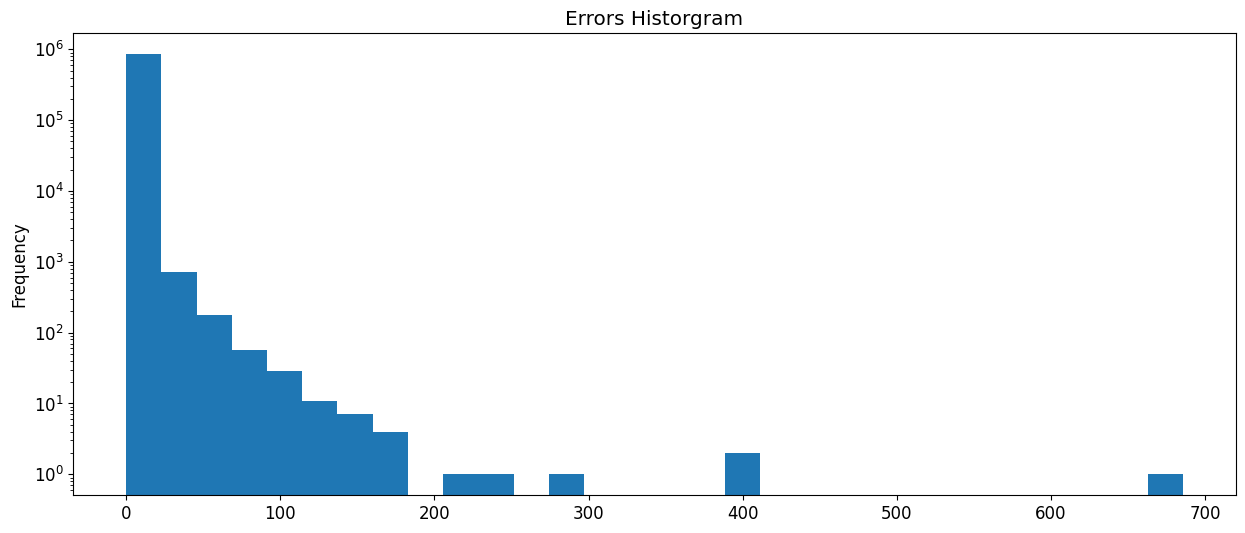

In [34]:
error_distribution(df_test_preds)

count    852786.000000
mean          0.040070
std           2.832291
min        -141.712585
25%          -0.844326
50%          -0.091216
75%           0.786599
max         685.595825
Name: error, dtype: float64


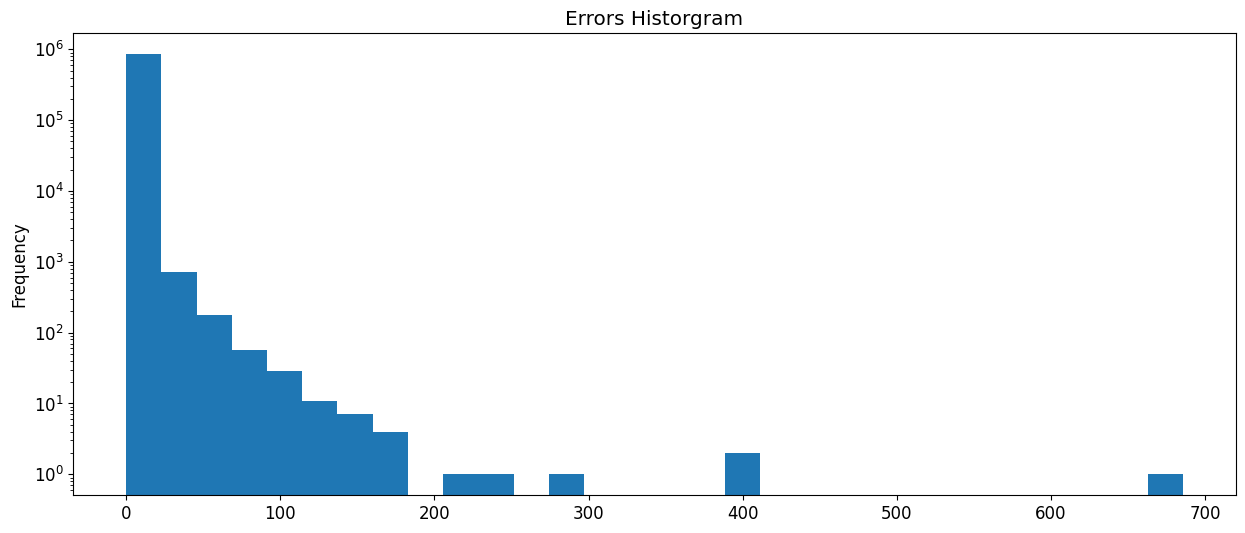

In [35]:
mask = df_test_preds['error'] > -1e5
error_distribution(df_test_preds, mask=mask)

## Spots Errors Distribution 

In [36]:
spots_error_distribution(df_test_preds)

count    1185.000000
mean        0.060775
std         0.253725
min        -0.690456
25%        -0.078558
50%         0.044990
75%         0.178389
max         2.560650
Name: error, dtype: float64


## Genes Errors Distribution 

In [37]:
genes_error_distribution(df_test_preds)

count    6279.000000
mean        0.035469
std         0.421183
min        -3.282639
25%        -0.162139
50%         0.040398
75%         0.242829
max        10.930294
Name: error, dtype: float64


## Errors Heat Map 

(1185, 6279)


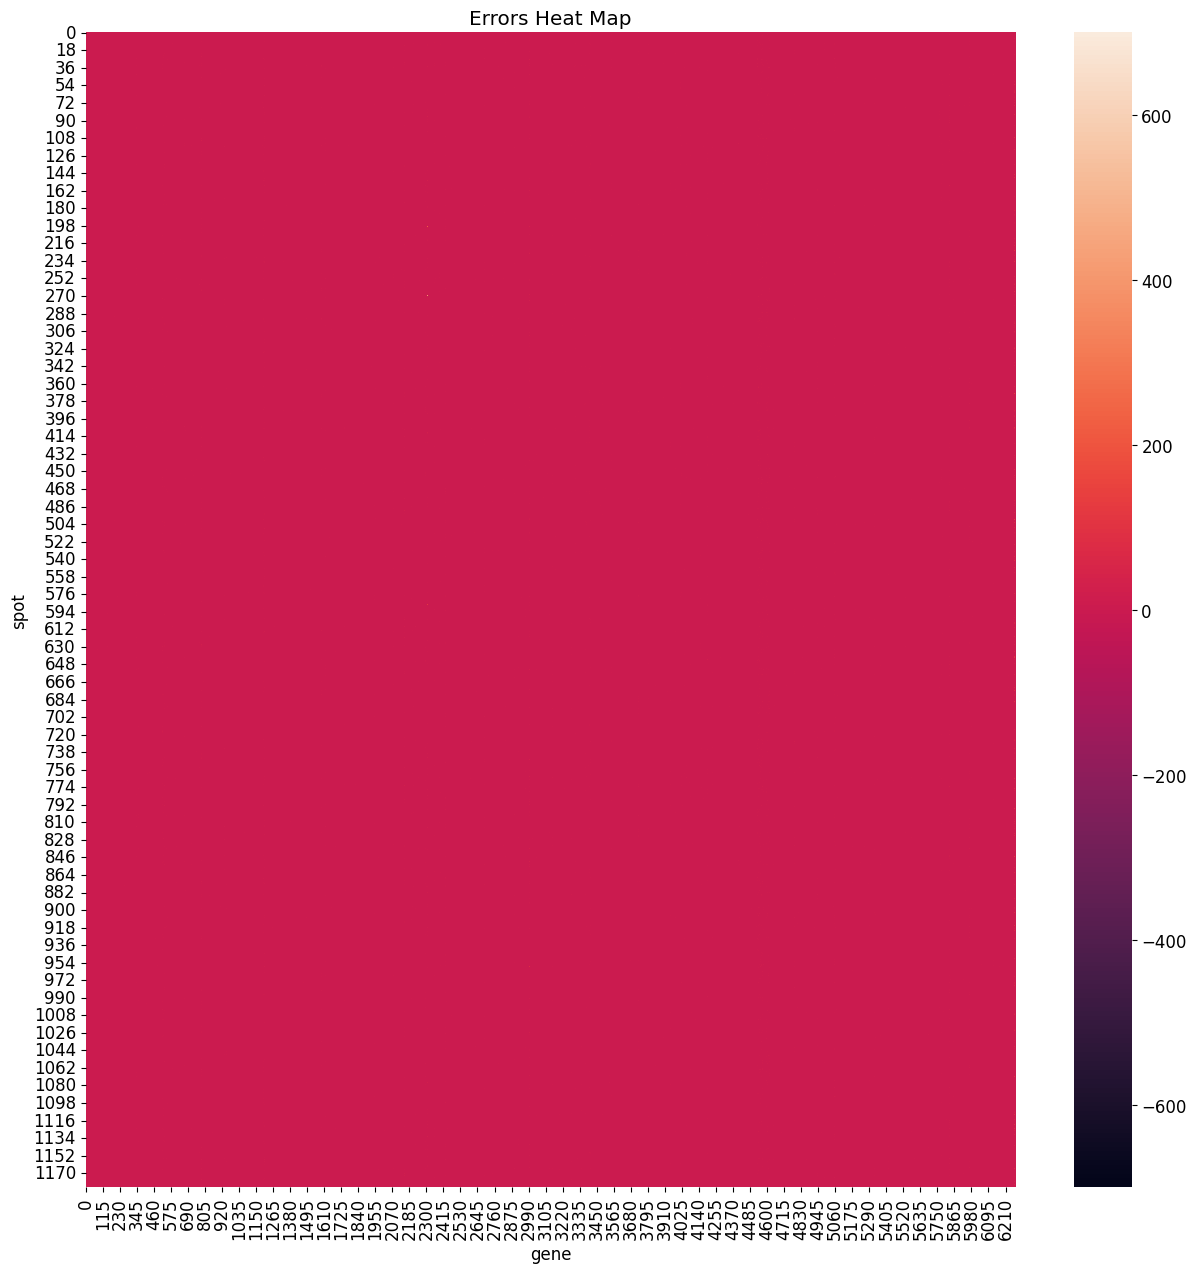

In [38]:
error_heat_map(df_test_preds, vmin=-700, vmax=700)

# PCA + KMeans Clustering 

In [39]:
_, obj, _, _ = get_expressions(min_counts=min_counts, min_cells=min_cells, apply_log=apply_log)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# spots: 1185 | # genes: 32285
New shape after filtering: (1185, 6279)
Log transformation step is finished in adata.X
Data shape: (7440615, 3)
Number of genes: 6279
Number of spots: 1185


In [40]:
# Load Ordinal Encoders
with open(path.join('/', 'data', 'NMF', 'genes_encoder.pkl'), 'rb') as f:
    oe_genes = pickle.load(f)
with open(path.join('/', 'data', 'NMF', 'spots_encoder.pkl'), 'rb') as f:
    oe_spots = pickle.load(f)

dl_train_nmf = torch.load(path.join('/', 'data', 'NMF', 'dl_train.pth'))
nmf_train_genes, nmf_train_spots, nmf_train_expressions = dl_train_nmf.dataset.get_all_data()
df_nmf_train_tmp = pd.DataFrame({'gene': nmf_train_genes.to('cpu'), 'spot': nmf_train_spots.to('cpu'), 'expression': nmf_train_expressions.to('cpu')})
df_nmf_train_tmp[['gene']] = oe_genes.inverse_transform(df_nmf_train_tmp[['gene']].values)
df_nmf_train_tmp[['spot']] = oe_spots.inverse_transform(df_nmf_train_tmp[['spot']].values)
df_nmf_train_matrix_tmp = df_nmf_train_tmp.pivot(index='spot', columns='gene', values='expression')

In [41]:
df_nmf_train = df_test_preds[['gene', 'spot', y_pred_col]].rename(columns={y_pred_col: 'expression'})
df_nmf_train[['gene']] = oe_genes.inverse_transform(df_nmf_train[['gene']].values)
df_nmf_train[['spot']] = oe_spots.inverse_transform(df_nmf_train[['spot']].values)
df_nmf_train_matrix = df_nmf_train.pivot(index='spot', columns='gene', values='expression')
df_nmf_train_matrix.fillna(df_nmf_train_matrix_tmp, inplace=True)
df_nmf_train_matrix.clip(lower=0, inplace=True)
display(df_nmf_train_matrix.head())
tmp_genes_locations = [obj.var.index.get_loc(key=gene_key) for gene_key in df_nmf_train_matrix.columns]
# Replace the values
obj.X[:, tmp_genes_locations] = df_nmf_train_matrix.values

gene,0610009B22Rik,0610009L18Rik,0610010K14Rik,0610012G03Rik,1110004F10Rik,1110008P14Rik,1110032A03Rik,1110038B12Rik,1110038F14Rik,1110051M20Rik,...,mt-Co1,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5
spot,,,,,,,,,,,,,,,,,,,,,
AAACAAGTATCTCCCA-1,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,...,62.000000,28.000000,60.877689,28.0,9.000000,13.93568,4.0,22.0,0.000000,0.0
AAACCGGGTAGGTACC-1,1.0,0.000000,3.146664,5.364994,3.0,7.916512,7.000000,2.086813,0.0,2.954018,...,1587.000000,962.000000,1292.000000,571.0,398.000000,318.00000,58.0,0.0,8.873619,31.0
AAACCGTTCGTCCAGG-1,0.0,0.604726,0.000000,6.000000,7.0,5.373639,2.318822,1.000000,0.0,8.000000,...,832.000000,470.216675,761.000000,339.0,0.000000,171.00000,42.0,278.0,3.000000,0.0
AAACGAGACGGTTGAT-1,1.0,0.000000,2.834485,0.000000,0.0,3.000000,1.000000,0.000000,3.0,4.000000,...,575.000000,0.000000,562.000000,0.0,178.000000,119.00000,25.0,175.0,3.000000,0.0
AAACTGCTGGCTCCAA-1,1.0,0.591290,2.000000,4.000000,0.0,0.000000,0.000000,0.000000,1.0,2.018585,...,814.842773,440.516296,691.000000,306.0,207.533966,0.00000,34.0,0.0,1.000000,27.0


/usr/local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Normalization step is finished in adata.X
Log transformation step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


<Figure size 640x480 with 0 Axes>

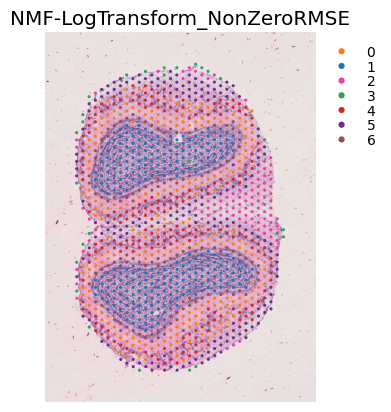

In [42]:
pca_kmeans_clustering(
    data_obj=obj, 
    title=f'NMF-{trial_name}'
)